In [89]:
import numpy as np, matplotlib.pyplot as plt, random, time, datetime
from functools import lru_cache
from pyquil import Program, get_qc
from pyquil.gates import *
import os
from pyquil.quilatom import quil_sin, quil_cos, Parameter
from pyquil.quilbase import DefGate
from pyquil.latex import display, to_latex
# import Peres_helpers as hf
import pickle
from collections import Counter

Z_SCORE = 3
N_SHOTS = 10_000

# Helpers
def dura(func):
	'''
	A wrapper function to calculate the time of any process we want.
	'''
	def wrapper(*args, **kwargs):
		start = time.time()
		print(f'{func.__name__} has started.')
		val = func(*args, **kwargs)
		ty_res = time.gmtime(time.time() - start)
		res = time.strftime("%H:%M:%S",ty_res)
		print(f'{func.__name__} completed in {res}')
		return val
	return wrapper

def params_real():
	'''
	Generates parameters to prepare random REAL quantum states.
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([(np.pi)*random.randint(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)
def params_complex():
	'''
	Generates parameters to prepare COMPLEX quantum states.
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([2*np.pi*random.uniform(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)

e = 0

# Gammas for different pairs of states.
def g(u):
    '''
    Calls the sigma function with different values of parameters correponding to the configurations, |ψ12>, |ψ1> and |ψ2>. Returns a
    dictionary with configurations as keys and output as values (which are lists).
    '''
    params = list(zip(*u)) # Unpack parameters
    theta, phi = params[0], params[1] # Store thetas and phis in seperate tuples.
    s12 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[np.pi/2]}) # Stores the output of the circuit run.
    counts_s12 = Counter([''.join(list(map(str, elem))) for elem in s12])
    
    #### NEW LINES
#     s1 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[0]}) # Stores the output of the circuit run.
#     counts_s1 = Counter([''.join(list(map(str, elem))) for elem in s1])
    
    s2 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[np.pi]}) # Stores the output of the circuit run.
    counts_s2 = Counter([''.join(list(map(str, elem))) for elem in s2])
    
    #### NEW LINES END

    return {'s12': counts_s12['01'], 's1': counts_s2['10'], 's2': counts_s2['00'], 'o12': s12, 'o1': s2}

# Computing all the three gammas.
# @dura # To calculate the time taken for all the circuits to run.
def f(u):
	'''
	Calls the g function to run the circuit for different configurations and returns a dictionary with 'a', 'b', 'c' as keys and the corresponding 
	outputs of the three configurations. This marks the end of what the Quantum computer must be used for. After this it is all about post-
	processing the data.
	'''
	alpha = g([u[0], u[1]]) # Running for alpha
	beta = g([u[1], u[2]]) # Running for beta
	gamma = g([u[2], u[0]]) # Running for gamma

	res = {'a': alpha, 'b': beta, 'c': gamma}

	return res

def get_gammas(counts, N):
    res = {}
    for gamma in counts.keys():
        counts_12 = Counter([''.join(list(map(str, elem))) for elem in counts[gamma]['o12'][:N]])['01']
        counts_1 = Counter([''.join(list(map(str, elem))) for elem in counts[gamma]['o1'][:N]])['01']
        counts_2 = Counter([''.join(list(map(str, elem))) for elem in counts[gamma]['o1'][:N]])['11']
        #Counter([''.join(list(map(str, elem))) for elem in s2])
        g = (2*counts_12 - counts_1 - counts_2) / (2 * np.sqrt(counts_1*counts_2))
        res[gamma] = g

    res['F'] = res['a']**2 + res['b']**2 + res['c']**2 - 2 * res['a'] * res['b'] * res['c']
    return res

def circuit(qubit1, qubit2):
    circ = Program()
    
    c = circ.declare('ro', 'BIT', 2)
    theta = circ.declare('theta', 'REAL', 2)
    phi = circ.declare('phi', 'REAL', 2)
    theta_m = circ.declare('theta_m', 'REAL')
    
    # Preparation of states.
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    circ += RY(theta[1], qubit2)
    circ += RZ(phi[1], qubit2)
    
#     circ += X(qubit1)
    
    # Measuring in psi+ basis
    circ += CNOT(qubit1, qubit2)
    circ += RY(-theta_m, qubit1)
#     circ += H(qubit1)
    
    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    
    circ.wrap_in_numshots_loop(N_SHOTS)
    
    return circ

def gamma_theory(data):
    u = data['State_params']
    g12 = np.cos(u[1][1] - u[0][1])
    g23 = np.cos(u[2][1] - u[1][1])
    g31 = np.cos(u[0][1] - u[2][1])
    
    data['Gammas_theory'] = {'a': g12, 'b': g23, 'c': g31}
    
    f = g12**2 + g23**2 + g31**2 - 2 * g12 * g23 * g31
    
    data['Gammas_theory']['F'] = f
    
    return data

Z_SCORE = 3
N_SHOTS = 10_000

In [90]:
datetime.date.today()

datetime.date(2021, 6, 23)

In [91]:
result_list = []
q1, q2 = 12, 25
trial=2
engine = 'qvm'
folder = f'product_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots_trial_{trial}'
# folder = f'product_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots'
os.system(f'mkdir {folder}')

qc = get_qc('Aspen-9', as_qvm=True) # Initialise QPU.
# qc = get_qc('2q-qvm')

circ = circuit(q1,q2)
exe = qc.compile(circ)

for i in range(10):
    data = {}
    data['State_params'] = params_complex()

    data['Counts'] = f(data['State_params'])
    
    result_list.append(data)

    print(f'Done with iteration {i}', end='\r')

with open(f'{folder}/result_list_trial_{trial}', 'wb') as file:
    pickle.dump(result_list, file)

In [92]:
# with open(f'product_peres_Aspen_2021-06-21_12_25_bits_10000_shots_trial_1/result_list_trial_{1}', 'rb') as file:
#     res_list = pickle.load(file)
# with open(f'product_peres_Aspen_2021-06-21_12_25_bits_10000_shots_trial_2/result_list_trial_{2}', 'rb') as file:
#     res_list.append(pickle.load(file))
with open(f'{folder}/result_list_trial_{trial}', 'rb') as file:
    res_list = pickle.load(file)

In [93]:
len(res_list)

10

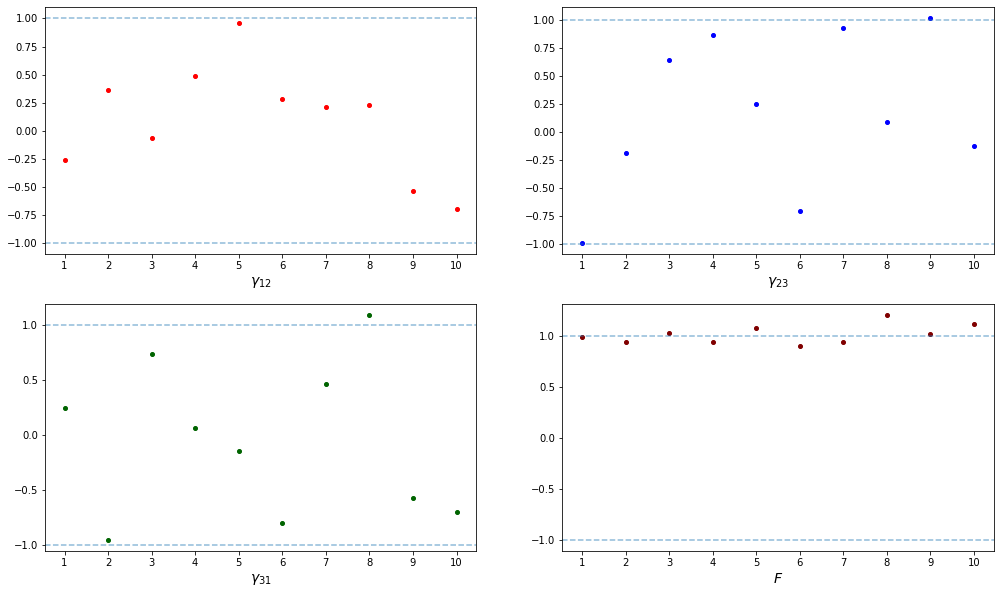

In [94]:
sub_N =10000
fig = plt.figure(figsize=(17, 10))
for sub_N in [sub_N]:
    all_a = []
    all_b = []
    all_c = []
    all_F = []

    all_a_theory = []
    all_b_theory = []
    all_c_theory = []
    all_F_theory = []

    all_a_errors = []
    all_b_errors = []
    all_c_errors = []
    all_F_errors = []

    for data in result_list:
        data['Gamma'] = get_gammas(data['Counts'], sub_N)
        all_a.append(data['Gamma']['a'])
        all_b.append(data['Gamma']['b'])
        all_c.append(data['Gamma']['c'])
        all_F.append(data['Gamma']['F'])

    x = np.array(list(range(1,len(result_list)+1)))
#     fig = plt.figure(figsize=(17,10))
    plt.subplot(2,2,1)
    plt.plot(x, all_a, 'o', color='red', markersize=4)
    plt.axhline(y=1, ls='dashed', alpha=0.5)
    plt.axhline(y=-1, ls='dashed', alpha=0.5)
    plt.xticks(x)
    plt.xlabel('$\\gamma_{12}$', size=14)

    plt.subplot(2,2,2)
    plt.plot(x, all_b, 'o', color='blue', markersize=4)
    plt.axhline(y=1, ls='dashed', alpha=0.5)
    plt.axhline(y=-1, ls='dashed', alpha=0.5)
    plt.xticks(x)
    plt.xlabel('$\\gamma_{23}$', size=14)

    plt.subplot(2,2,3)
    plt.plot(x, all_c, 'o', color='darkgreen', markersize=4)
    plt.axhline(y=1, ls='dashed', alpha=0.5)
    plt.axhline(y=-1, ls='dashed', alpha=0.5)
    plt.xticks(x)
    plt.xlabel('$\\gamma_{31}$', size=14)

    plt.subplot(2,2,4)
    plt.plot(x, all_F, 'o', color='maroon', markersize=4)
    plt.axhline(y=1, ls='dashed', alpha=0.5)
    plt.axhline(y=-1, ls='dashed', alpha=0.5)
    plt.xticks(x)
    plt.xlabel('$F$', size=14)

#     plt.show()

# Statistical fluctuation through repetition

In [140]:
# result_list = []

q1, q2 = 12, 25
trial=2
# engine = 'qvm'
# folder = f'new_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots_trial_{trial}'
# os.system(f'mkdir {folder}')

qc = get_qc('Aspen-9', as_qvm=True) # Initialise QPU.

circ = circuit(q1,q2)
exe = qc.compile(circ)

for result in res_list:
    print(f"States {result['State_params']}", end='\n')
    result['CF99'] = {}
    result['CF100'] = {}
    result['Stats'] = {}
    data = {}
    data['State_params'] = result['State_params']
    data['a'] = []
    data['b'] = []
    data['c'] = []
    data['F'] = []
    for i in range(50):
    #     data = {}
    #     data['State_params'] = params_complex()

        Counts = f(data['State_params'])

    #     with open(f'{folder}/run_{i}', 'wb') as file:
    #         pickle.dump(data, file)

        all_gammas = get_gammas(Counts, sub_N)
        data['a'].append(all_gammas['a'])
        data['b'].append(all_gammas['b'])
        data['c'].append(all_gammas['c'])
        data['F'].append(all_gammas['F'])
        print(f'Done with iteration {i}', end='\r')

    #     result_list.append(data)

#     print(f'Done with iteration {i}', end='\r')

    samp = data['a']
    samp.sort()
    result['Stats']['a'] = samp
    result['CF99']['a'] = [samp[int(0.005 * len(samp))], samp[int(0.995 * len(samp))]]
    result['CF100']['a'] = [samp[0], samp[-1]]

    samp = data['b']
    samp.sort()
    result['Stats']['b'] = samp
    result['CF99']['b'] = [samp[int(0.005 * len(samp))], samp[int(0.995 * len(samp))]]
    result['CF100']['b'] = [samp[0], samp[-1]]

    samp = data['c']
    samp.sort()
    result['Stats']['c'] = samp
    result['CF99']['c'] = [samp[int(0.005 * len(samp))], samp[int(0.995 * len(samp))]]
    result['CF100']['c'] = [samp[0], samp[-1]]

    samp = data['F']
    samp.sort()
    result['Stats']['F'] = samp
    result['CF99']['F'] = [samp[int(0.005 * len(samp))], samp[int(0.995 * len(samp))]]
    result['CF100']['F'] = [samp[0], samp[-1]]
    
    
# with open(f'{folder}/result_list', 'wb') as file:
#     pickle.dump(result_list, file)

States [(1.624856462838205, 4.577726999959647), (1.5334632715520515, 4.618719120817586), (2.7716610386483316, 3.160524807474115)]
States [(0.4165665876847796, 1.3380873220067426), (1.7515437844549102, 4.950901872066199), (0.865023345804317, 4.580087134788987)]
States [(1.2358473722635301, 2.6406704249675674), (1.133039464405895, 5.4356397260931555), (1.2980482455760654, 6.190441597045996)]
States [(0.8004574749903834, 0.7733094915336839), (2.5124709435968033, 5.931842556242618), (0.6060821917787119, 4.744806438164855)]
States [(1.8056897148076398, 5.808508562344143), (2.830480354571345, 5.919315924065063), (2.5734652686786337, 4.692849548440272)]
States [(2.3352681581784713, 2.803826332568166), (1.1433754674548142, 0.6397765072491793), (0.7778999435492031, 5.338412180640358)]
States [(1.7144938669483791, 1.5494192409509349), (2.8696397015371975, 5.574774964573181), (2.0821126977586855, 1.2255394554981673)]
States [(1.6693141893503456, 0.9660788806629388), (1.5646020045508453, 1.0792991

In [141]:
all_a = []
all_b = []
all_c = []
all_F = []

all_cf_a = []
all_cf_b = []
all_cf_c = []
all_cf_F = []

all_mid_a = []
all_mid_b = []
all_mid_c = []
all_mid_F = []


for result in res_list:
    all_a.append(result['Gamma']['a'])
    all_b.append(result['Gamma']['b'])
    all_c.append(result['Gamma']['c'])
    all_F.append(result['Gamma']['F'])
    
    all_mid_a.append((result['CF100']['a'][1] + result['CF100']['a'][0])/2)
    all_mid_b.append((result['CF100']['b'][1] + result['CF100']['b'][0])/2)
    all_mid_c.append((result['CF100']['c'][1] + result['CF100']['c'][0])/2)
    all_mid_F.append((result['CF100']['F'][1] + result['CF100']['F'][0])/2)
    
    all_cf_a.append((result['CF100']['a'][1] - result['CF100']['a'][0])/2)
    all_cf_b.append((result['CF100']['b'][1] - result['CF100']['b'][0])/2)
    all_cf_c.append((result['CF100']['c'][1] - result['CF100']['c'][0])/2)
    all_cf_F.append((result['CF100']['F'][1] - result['CF100']['F'][0])/2)
    
    
    

Text(0, 0.5, '$F$')

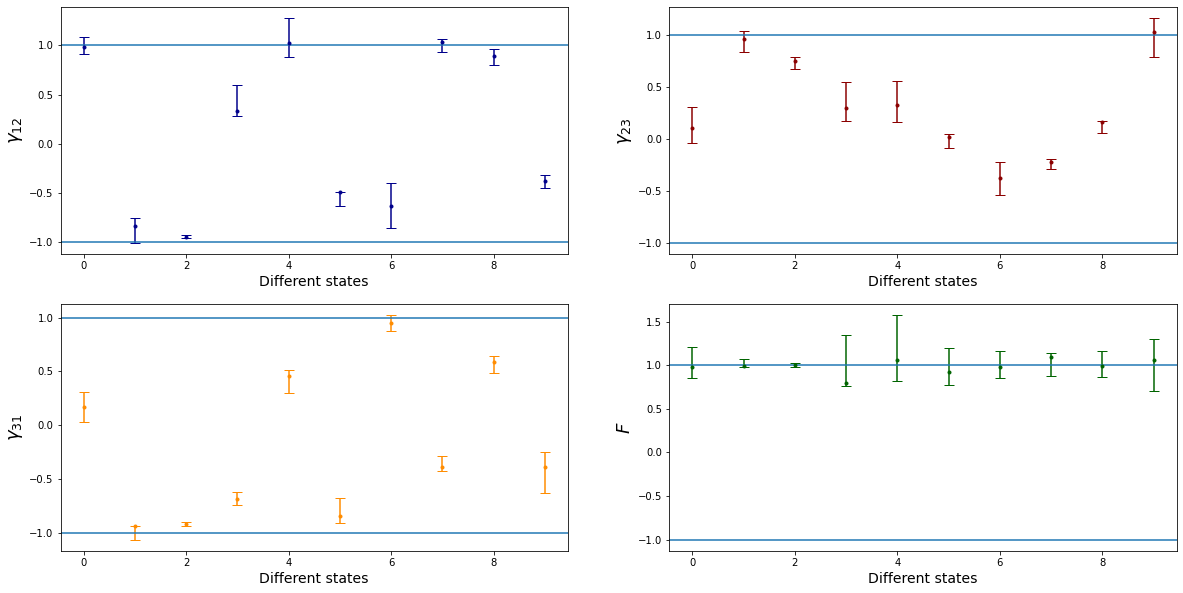

In [142]:
x = np.arange(len(all_a))
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.axhline(y=-1)
plt.axhline(y=1)
plt.plot(x, all_a, '.', color='darkblue')
plt.errorbar(x, all_mid_a, yerr=[all_cf_a, all_cf_a], marker='', fmt='', capsize=5, ls='', color='darkblue')
plt.xlabel('Different states', size=14)
plt.ylabel('$\gamma_{12}$', size=18)

plt.subplot(2,2,2)
plt.axhline(y=-1)
plt.axhline(y=1)
plt.plot(x, all_b, '.', color='darkred')
plt.errorbar(x, all_mid_b, yerr=[all_cf_b, all_cf_b], marker='', fmt='', capsize=5, ls='', color='darkred')
plt.xlabel('Different states', size=14)
plt.ylabel('$\gamma_{23}$', size=18)

plt.subplot(2,2,3)
plt.axhline(y=-1)
plt.axhline(y=1)
plt.plot(x, all_c, '.', color='darkorange')
plt.errorbar(x, all_mid_c, yerr=[all_cf_c, all_cf_c], marker='', fmt='', capsize=5, ls='', color='darkorange')
plt.xlabel('Different states', size=14)
plt.ylabel('$\gamma_{31}$', size=18)

plt.subplot(2,2,4)
plt.axhline(y=-1)
plt.axhline(y=1)
plt.plot(x, all_F, '.', color='darkgreen')
plt.errorbar(x, all_mid_F, yerr=[all_cf_F, all_cf_F], marker='', fmt='', capsize=5, ls='', color='darkgreen')
plt.xlabel('Different states', size=14)
plt.ylabel('$F$', size=18)

# plt.savefig(f'product_peres_on_{datetime.date.today()}.pdf', bbox_inches='tight')

In [384]:
with open(f'product_peres_with_error_from_qvm_{datetime.date.today()}', 'wb') as file:
    pickle.dump(result_list, file)

# Pure statistical error

In [16]:
x = list(range(10))

In [19]:
x[:21]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [31]:
# Good state params
good_sp = [res_list[i]['State_params'] for i in [0,1,2,6,7]]
good_sp

[[(2.2643917376806413, 1.4092148068944585),
  (1.2196591504966108, 4.148394322725507),
  (2.7314796585224057, 0.6622316094082566)],
 [(1.9860241475277391, 4.438849673812229),
  (2.22327815594402, 2.909435861433363),
  (0.7822388440433669, 4.079531736035741)],
 [(1.9536982700306442, 0.7243762434357844),
  (1.5756268430063722, 3.7691081945710656),
  (2.1961767849885168, 2.837030056536219)],
 [(1.0977255769543777, 5.589484433163971),
  (0.6483948742005643, 0.2827915572231466),
  (2.2069970435274184, 5.508972601778685)],
 [(2.3596960276539742, 4.429645196100462),
  (0.893037797503311, 5.8738392420736245),
  (1.218767424722084, 0.1907557515304096)]]

In [34]:
with open(f'good_states_{datetime.date.today()}_{15}_states.pkl', 'wb') as file:
    pickle.dump(gs + good_sp, file)

In [36]:
with open(f'good_states_{datetime.date.today()}_{15}_states.pkl', 'rb') as file:
    gs = pickle.load(file)
len(gs)

15

In [ ]:
result_list = []
q1, q2 = 12, 25
trial=2
engine = 'Aspen'
folder = f'product_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots_trial_{trial}'
# folder = f'product_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots'
os.system(f'mkdir {folder}')

qc = get_qc('Aspen-9')#, as_qvm=True) # Initialise QPU.
# qc = get_qc('2q-qvm')

circ = circuit(q1,q2)
exe = qc.compile(circ)

for i in range(4):
    data = {}
    data['State_params'] = params_complex()

    data['Counts'] = f(data['State_params'])
    
    result_list.append(data)

    print(f'Done with iteration {i}', end='\r')

with open(f'{folder}/result_list_trial_{trial}', 'wb') as file:
    pickle.dump(result_list, file)

In [45]:
len(gs)

15

In [33]:
len(gs + good_sp)

15

In [95]:
with open('product_peres_Aspen_2021-06-23_12_25_bits_10000_shots_trial_1/result_list_trial_1', 'rb') as file:
    result_list = pickle.load(file)

In [96]:
len(asp_res)

15

In [99]:
sub_N =10000
def plot_all(result_list, sub_N):
    fig = plt.figure(figsize=(17, 10))
    for sub_N in [sub_N]:
        all_a = []
        all_b = []
        all_c = []
        all_F = []

        all_a_theory = []
        all_b_theory = []
        all_c_theory = []
        all_F_theory = []

        all_a_errors = []
        all_b_errors = []
        all_c_errors = []
        all_F_errors = []

        for data in result_list:
            data['Gamma'] = get_gammas(data['Counts'], sub_N)
            all_a.append(data['Gamma']['a'])
            all_b.append(data['Gamma']['b'])
            all_c.append(data['Gamma']['c'])
            all_F.append(data['Gamma']['F'])

        x = np.array(list(range(1,len(result_list)+1)))
    #     fig = plt.figure(figsize=(17,10))
        plt.subplot(2,2,1)
        plt.plot(x, all_a, 'o', color='red', markersize=4)
        plt.axhline(y=1, ls='dashed', alpha=0.5)
        plt.axhline(y=-1, ls='dashed', alpha=0.5)
        plt.xticks(x)
        plt.xlabel('$\\gamma_{12}$', size=14)

        plt.subplot(2,2,2)
        plt.plot(x, all_b, 'o', color='blue', markersize=4)
        plt.axhline(y=1, ls='dashed', alpha=0.5)
        plt.axhline(y=-1, ls='dashed', alpha=0.5)
        plt.xticks(x)
        plt.xlabel('$\\gamma_{23}$', size=14)

        plt.subplot(2,2,3)
        plt.plot(x, all_c, 'o', color='darkgreen', markersize=4)
        plt.axhline(y=1, ls='dashed', alpha=0.5)
        plt.axhline(y=-1, ls='dashed', alpha=0.5)
        plt.xticks(x)
        plt.xlabel('$\\gamma_{31}$', size=14)

        plt.subplot(2,2,4)
        plt.plot(x, all_F, 'o', color='maroon', markersize=4)
        plt.axhline(y=1, ls='dashed', alpha=0.5)
        plt.axhline(y=-1, ls='dashed', alpha=0.5)
        plt.xticks(x)
        plt.xlabel('$F$', size=14)
        
        plt.show()

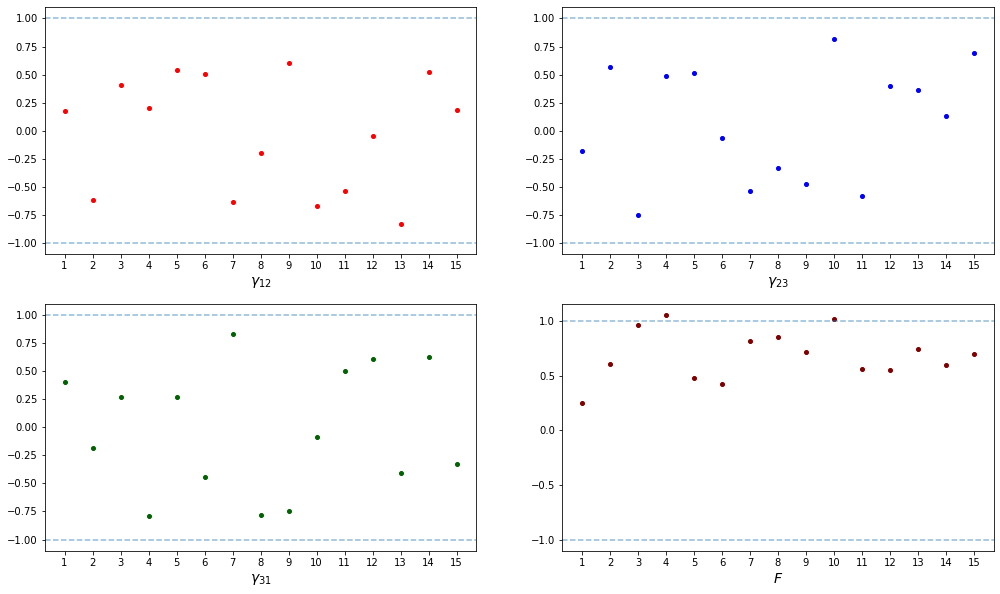

In [102]:
plot_all(result_list, 1600)

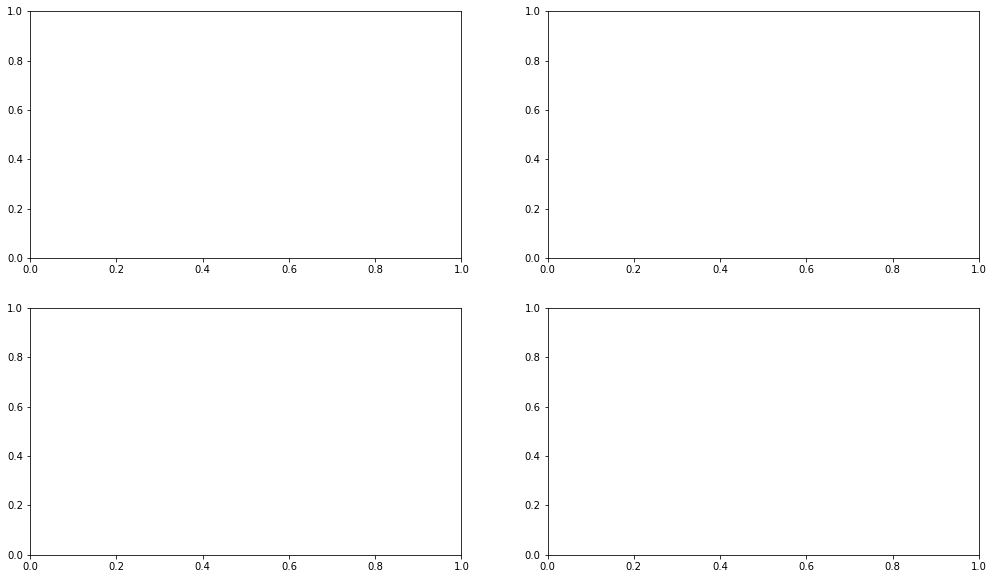

In [110]:
fig = plt.figure(figsize=(17,10))
ax12 = fig.add_subplot(2,2,1)
ax23 = fig.add_subplot(2,2,2)
ax31 = fig.add_subplot(2,2,3)
axF = fig.add_subplot(2,2,4)
ax12.plot([],[], 'o')
ax23.plot([],[], 'o')
ax21.plot([],[], 'o')
ax12.plot([],[], 'o')
def animate(i):
    plot_all(result_list, 1000*i+1000)
    return None

# anim = animation.FuncAnimation(fig, animate, frames=10)
# HTML(anim.to_html5_video())

In [107]:
from matplotlib import animation
from IPython.display import HTML